# MC check on estimated covariance matrix

We perform a Monte Carlo test on the correctness of the estimated covariance matrix.

- we simulate 100,000 samples from independent Gaussian noise in polar coordinates
- we add them to a constant, representing the actual measurement, thus obtaining noisy measurements in polar coordinates
- we transform the noisy measurements and the actual measurements in Cartesian coordinates
- we subract the actual measurements from the noisy measurements in Cartesian coordinates, thus obtaining the noise
- we compute the sample mean and covariance of the noise
- we expect the sample covariance to be in agreement with out formulae.

## Setup

In [170]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [171]:
sys.path.append('..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
samples = 100000

## MC Samples
Try also with `theta=-1` and `theta_sd=1` and with `theta=-1` and `theta_sd=0.01`.

In [173]:
np.random.seed(11)

v = 1
theta = -1*0#-10 * np.pi / 180

v_sd = 0.01
theta_sd = 0.01 #1 * np.pi / 180

v_var, theta_var = v_sd ** 2, theta_sd ** 2

v_noise = np.random.normal(0, v_sd, size=samples)
theta_noise = np.random.normal(0, theta_sd, size=samples)

noisy_measurements = (v + v_noise) * np.exp(1j * (theta + theta_noise))
actual_measurements = v * np.exp(1j * theta)
cartesian_noise = noisy_measurements - actual_measurements

actual_mean = (np.mean(np.real(cartesian_noise)), np.mean(np.imag(cartesian_noise)))
actual_covariance = np.cov(np.real(cartesian_noise), np.imag(cartesian_noise))

In [174]:
actual_mean

(1.8307871291441437e-05, 3.663949941278853e-05)

In [175]:
actual_covariance

array([[9.98089129e-05, 9.42060193e-07],
       [9.42060193e-07, 9.96960771e-05]])

## Covariance of the first-order approximation with real measurements

In [176]:
covariance_first_order = np.array([
    [np.cos(theta)**2 * v_var + v**2 * np.sin(theta)**2 * theta_var, np.cos(theta) * np.sin(theta) * (v_var - v**2 * theta_var)], 
    [np.cos(theta) * np.sin(theta) * (v_var - v**2 * theta_var), np.sin(theta)**2 * v_var + v**2 * np.cos(theta)**2 * theta_var]
])
covariance_first_order

array([[0.0001, 0.    ],
       [0.    , 0.0001]])

It looks like the estimation of the variances is quite accurate, while the one of the covariances is not. Not even the sign is correct.

**TODO**: double check the derivation of the covariance.

## Covariance with actual measurements
Implementing equation 6 in the notes.

In [177]:
cov_with_actual_11 = v **2 * np.exp(-theta_var) * (np.cos(theta)**2 * (np.cosh(theta_var) - 1) + np.sin(theta)**2 * np.sinh(theta_var)) + v_var * np.exp(-theta_var) * (np.cos(theta)**2 * np.cosh(theta_var) + np.sin(theta)**2 * np.sinh(theta_var))
cov_with_actual_22 = v **2 * np.exp(-theta_var) * (np.sin(theta)**2 * (np.cosh(theta_var) - 1) + np.cos(theta)**2 * np.sinh(theta_var)) + v_var * np.exp(-theta_var) * (np.sin(theta)**2 * np.cosh(theta_var) + np.cos(theta)**2 * np.sinh(theta_var))
cov_with_actual_12 = np.sin(theta) * np.cos(theta) * np.exp(-2 * theta_var) * (v_var + v**2 * (1 - np.exp(theta_var)))
covariance_with_actual = np.array([
    [cov_with_actual_11, cov_with_actual_12],
    [cov_with_actual_12, cov_with_actual_22]
])
covariance_with_actual

array([[ 9.99950005e-05, -0.00000000e+00],
       [-0.00000000e+00,  9.99999997e-05]])

## Average true covariance
Implementing equation 8 in the notes.  
In first approximation, we use it with the actual measurements.

In [178]:
cov_avg_true_11 = v**2 * np.exp(-2*theta_var) * (np.cos(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.cos(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))
cov_avg_true_22 = v**2 * np.exp(-2*theta_var) * (np.sin(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.sin(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))
cov_avg_true_12 = np.sin(theta) * np.cos(theta) * np.exp(-4*theta_var) * (v_var + (v**2 + v_var)*(1 - np.exp(theta_var)))
covariance_average_true = np.array([
    [cov_avg_true_11, cov_avg_true_12],
    [cov_avg_true_12, cov_avg_true_22]
])
covariance_average_true

array([[ 9.99950025e-05, -0.00000000e+00],
       [-0.00000000e+00,  1.00009997e-04]])

Then, we use the noisy measurements, as in the realistic case.

In [179]:
def cov_avg_true_real(measurements, magnitude_var, phase_var):
    v, theta = np.abs(measurements), np.angle(measurements)
    v_var = magnitude_var
    theta_var = phase_var
    return v**2 * np.exp(-2*theta_var) * (np.cos(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.cos(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.sin(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))

def cov_avg_true_imag(measurements, magnitude_var, phase_var):
    v, theta = np.abs(measurements), np.angle(measurements)
    v_var = magnitude_var
    theta_var = phase_var
    return v**2 * np.exp(-2*theta_var) * (np.sin(theta)**2 * (np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (np.sinh(2*theta_var) - np.sinh(theta_var))) + v_var * np.exp(-2*theta_var) * (np.sin(theta)**2 * (2*np.cosh(2*theta_var) - np.cosh(theta_var)) + np.cos(theta)**2 * (2*np.sinh(2*theta_var) - np.sinh(theta_var)))

def cov_avg_true_real_imag(measurements, magnitude_var, phase_var):
    v, theta = np.abs(measurements), np.angle(measurements)
    v_var = magnitude_var
    theta_var = phase_var
    return np.sin(theta) * np.cos(theta) * np.exp(-4*theta_var) * (v_var + (v**2 + v_var)*(1 - np.exp(theta_var)))


cov_avg_true_11 = cov_avg_true_real(noisy_measurements, v_var, theta_var)
cov_avg_true_22 = cov_avg_true_imag(noisy_measurements, v_var, theta_var)
cov_avg_true_12 = cov_avg_true_real_imag(noisy_measurements, v_var, theta_var)
cov_avg_true_11

array([9.99956375e-05, 9.99949145e-05, 9.99948297e-05, ...,
       9.99961803e-05, 9.99951670e-05, 9.99948166e-05])

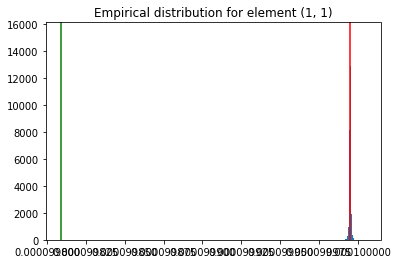

In [180]:
plt.hist(cov_avg_true_11, bins = 100)
plt.title('Empirical distribution for element (1, 1)')
plt.axvline(actual_covariance[0, 0], color='green');
plt.axvline(covariance_average_true[0, 0], color='red');

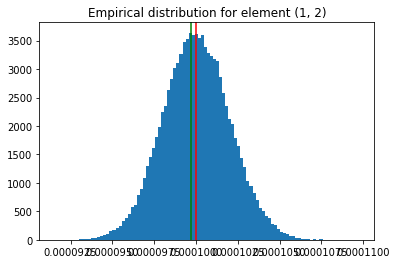

In [181]:
plt.hist(cov_avg_true_22, bins = 100)
plt.title('Empirical distribution for element (1, 2)')
plt.axvline(actual_covariance[1, 1], color='green');
plt.axvline(covariance_average_true[1, 1], color='red');

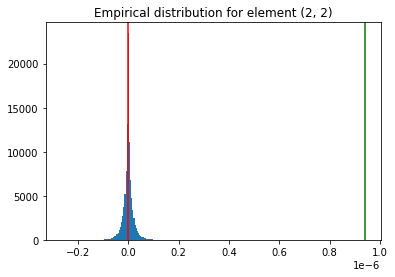

In [182]:
plt.hist(cov_avg_true_12, bins = 100)
plt.title('Empirical distribution for element (2, 2)')
plt.axvline(actual_covariance[0, 1], color='green');
plt.axvline(covariance_average_true[0, 1], color='red');